## Load libraries

In [1]:
!pip install -q -r requirements.txt

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.1 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && mv pytorch-lr-finder lrfinder

Cloning into 'pytorch-lr-finder'...
remote: Enumerating objects: 45, done.
remote: Total 45 (delta 0), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (45/45), done.
Checking connectivity... done.


In [3]:
!pip install -q -r lrfinder/requirements.txt

  Could not find a version that satisfies the requirement pkg-resources==0.0.0 (from -r lrfinder/requirements.txt (line 6)) (from versions: )
No matching distribution found for pkg-resources==0.0.0 (from -r lrfinder/requirements.txt (line 6))
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import sys
import os
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import models, transforms

from ignite.engine import Events
from scripts.ignite import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import  EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import LinearCyclicalScheduler, CosineAnnealingScheduler

from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split

from scripts.evaluate import eval_model 

from lrfinder.lr_finder import LRFinder

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Define dataset and model

In [10]:
img_dir = '../input/rxrxairgb'
path_data = '../input/rxrxaicsv'
device = 'cuda'
batch_size = 256
learning_rate=1e-10
torch.manual_seed(0)
model_name = 'resnet18'

In [11]:
jitter = (0.6, 1.4)
class ImagesDS(D.Dataset):
    # taken textbook from https://arxiv.org/pdf/1812.01187.pdf
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=jitter, contrast=jitter, saturation=jitter, hue=.1),
        transforms.RandomHorizontalFlip(p=0.5),
        # PCA Noise should go here,
        transforms.ToTensor(),
        transforms.Normalize(mean=(123.68, 116.779, 103.939), std=(58.393, 57.12, 57.375))
    ])
    
    transform_validation = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(123.68, 116.779, 103.939), std=(58.393, 57.12, 57.375))
    ])

    def __init__(self, df, img_dir=img_dir, mode='train', validation=False, site=1):
        self.records = df.to_records(index=False)
        self.site = site
        self.mode = mode
        self.img_dir = img_dir
        self.len = df.shape[0]
        self.validation = validation
        
    @staticmethod
    def _load_img_as_tensor(file_name, validation):
        with Image.open(file_name) as img:
            if not validation:
                return ImagesDS.transform_train(img)
            else:
                return ImagesDS.transform_validation(img)

    def _get_img_path(self, index, site=1):
        experiment, well, plate = self.records[index].experiment, self.records[index].well, self.records[index].plate
        return f'{self.img_dir}/{self.mode}/{experiment}_{plate}_{well}_s{site}.jpeg'
        
    def __getitem__(self, index):
        img1 = self._load_img_as_tensor(self._get_img_path(index), self.validation)
        if self.mode == 'train':
            return img1, int(self.records[index].sirna)
        else:
            return img1, self.records[index].id_code

    def __len__(self):
        return self.len

In [12]:
# dataframes for training, cross-validation, and testing
df = pd.read_csv(path_data+'/train.csv')
df_train, df_val = train_test_split(df, test_size = 0.1, random_state=42)
df_test = pd.read_csv(path_data+'/test.csv')

# pytorch training dataset & loader
ds = ImagesDS(df_train, mode='train', validation=False)
loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

# pytorch cross-validation dataset & loader
ds_val = ImagesDS(df_val, mode='train', validation=True)
val_loader = D.DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)

# pytorch test dataset & loader
ds_test = ImagesDS(df_test, mode='test', validation=True)
tloader = D.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [13]:
classes = 1108

model = getattr(models, model_name)(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, classes)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(loader, end_lr=10, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


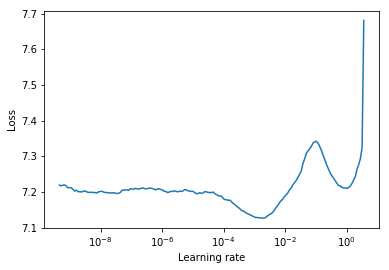

In [16]:
lr_finder.plot()